In [1]:
from esm.pretrained import ESM3_structure_encoder_v0, ESM3_structure_decoder_v0
from esm.utils.structure.protein_chain import ProteinChain

import torch
import numpy as np

import sys
sys.path.append('/burg/home/jb5005')
import os
import pytorch_lightning as pl

from huggingface_hub import login
from struct_diff.data.flow import interpolate
from struct_diff.data.datamodule import ContinuousStructTokenDataModule
from struct_diff.model.models import TransformerModel
from struct_diff.model.layers import TransformerLayer, positional_encoding, time_encoding

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
decoder = ESM3_structure_decoder_v0(device=device)
encoder = ESM3_structure_encoder_v0(device=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab = decoder.embed(torch.arange(0, 4100, device=device))

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/pmglo

In [3]:
#Full Decode 
def decode(struct_tokens):
    #Add BOS and EOS
    
    BOS_token = torch.tensor([4098], device = device)
    EOS_token = torch.tensor([4097], device = device)

    prepped_tokens = torch.cat([BOS_token, struct_tokens, EOS_token]).unsqueeze(0)
    output =  decoder.decode(prepped_tokens)
    bb_pred = output['bb_pred'].squeeze()
    bb_pred = bb_pred.cpu().detach().numpy()
    temp_chain = ProteinChain.from_backbone_atom_coordinates(bb_pred)
    return temp_chain


In [4]:
def convert_continuous_to_discrete_token(x1):
    """
    Maps backwards from the continuous token embedding to the discrete version
    Computes the Euclidean distance between the continuous token and all discrete tokens, 
    then selects discrete with the smallest distance

    args: x1 [BxLx1280]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    decoder = ESM3_structure_decoder_v0(device=device)
    vocab = decoder.embed(torch.arange(0, 4100, device=device))  # [4100, 1280]
    
    # Ensure vocab matches the last dimension of x1
    if vocab.size(-1) != x1.size(-1):
        raise ValueError("Mismatch in embedding dimensions between x1 and vocab.")
    
    # Compute distances [B, L, 4100]
    distances = torch.cdist(x1, vocab, p=2)
    
    # Get the closest discrete tokens
    closest_indices = distances.argmin(dim=-1)  # [B, L]
    min_distances = torch.gather(distances, -1, closest_indices.unsqueeze(-1)).squeeze(-1)  # [B, L]

    distances_for_second_min = distances.clone()
    distances_for_second_min.scatter_(-1, closest_indices.unsqueeze(-1), float('inf'))
    
    # Find the second closest token
    second_closest_indices = distances_for_second_min.argmin(dim=-1) # [B, L]
    second_min_distances = torch.gather(distances, -1, second_closest_indices.unsqueeze(-1)).squeeze(-1) # [B, L]

    
    return closest_indices.squeeze(), min_distances, second_min_distances

In [25]:
model = TransformerModel(lr=1e-5, n_blocks=1, hidden_size=1)
checkpoint = torch.load("/burg/home/jb5005/base.ckpt")
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
model.eval()

model_wide = TransformerModel(lr=1e-5, n_blocks=2, hidden_size=4)
wide_checkpoint = torch.load("/pmglocal/jb5005/wandb_files/struct_diff_v0/lm3bdobf/checkpoints/epoch=553-step=346250.ckpt")
model_wide.load_state_dict(wide_checkpoint['state_dict'])
model_wide = model_wide.to(device)
model_wide.eval()

model_widest = TransformerModel(lr=1e-5, n_blocks=2, hidden_size=4)
widest_checkpoint = torch.load('/burg/home/jb5005/q_0_1.ckpt')
model_widest.load_state_dict(widest_checkpoint['state_dict'])
model_widest = model_widest.to(device)
model_widest.eval()

/tmp/ipykernel_1942209/41561505.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/burg/home/jb5005/base.ckpt")
/tmp/ipykernel_1942209/41561505.py

TransformerModel(
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
      )
      (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=1280, out_features=5120, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=5120, out_features=1280, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
)

In [6]:
def add_special_token_columns(tensor):
    bos_col = torch.full((tensor.shape[0], 1), 4098, device=tensor.device, dtype=tensor.dtype)
    eos_col = torch.full((tensor.shape[0], 1), 4097, device=tensor.device, dtype=tensor.dtype)
    
    return torch.cat([bos_col, tensor, eos_col], dim=1)

In [7]:
datamodule = ContinuousStructTokenDataModule(base_path = '/pmglocal/jb5005/struct_diff_data/data', 
                                             df_path = '/burg/home/jb5005/struct_diff/data/seq_len.csv',
                                             num_workers = 0,
                                             batch_size = 256,)
datamodule.setup('train')
dataloader = datamodule.train_dataloader()
dataloader.dataset
# batch = dataloader.dataset.__getitem__(5).unsqueeze(0).to(device)
batch = next(iter(dataloader)).to(device)

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


# Plot MSE as a Function of Timestep

In [13]:
t_steps = torch.arange(0,100, device = device)
noise = 0.001* torch.randn(batch.shape, device = device)
base_mse_arr = []
for t in t_steps:
    x_t = t/100*batch + (1-t/100)*noise
    pred = model(x_t, t/100)
    mse = (((batch-noise) - pred) ** 2).mean()
    base_mse_arr.append(mse.item())

In [14]:
t_steps = torch.arange(0,100, device = device)
noise = 0.01* torch.randn(batch.shape, device = device)
wide_mse_arr = []
for t in t_steps:
    x_t = t/100*batch + (1-t/100)*noise
    pred = model_wide(x_t, t/100)
    mse = (((batch-noise) - pred) ** 2).mean()
    wide_mse_arr.append(mse.item())

In [26]:
t_steps = torch.arange(0,100, device = device)
noise = 0.1* torch.randn(batch.shape, device = device)
widest_mse_arr = []
for t in t_steps:
    x_t = t/100*batch + (1-t/100)*noise
    pred = model_widest(x_t, t/100)
    mse = (((batch-noise) - pred) ** 2).mean()
    widest_mse_arr.append(mse.item())

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1942209/265735730.py:1: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(t_steps.detach().cpu().numpy()/100, base_mse_arr, label = 'Base: $q_0 = \mathcal{N}(0,0.001)$')
/tmp/ipykernel_1942209/265735730.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(t_steps.detach().cpu().numpy()/100, wide_mse_arr, label = 'Wider $q_0 = \mathcal{N}(0,0.01)$')
/tmp/ipykernel_1942209/265735730.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(t_steps.detach().cpu().numpy()/100, widest_mse_arr, label = 'Widest $q_0 = \mathcal{N}(0,0.1)$')


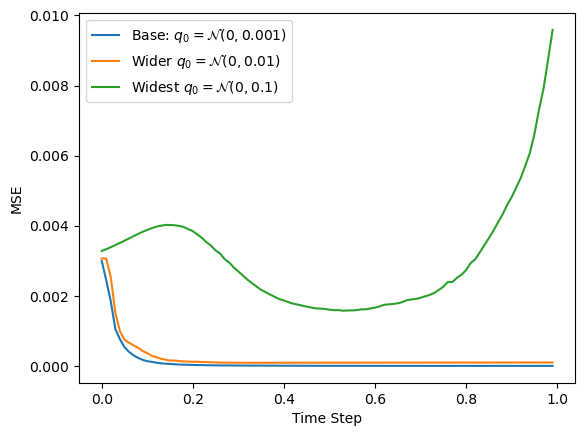

In [27]:
plt.plot(t_steps.detach().cpu().numpy()/100, base_mse_arr, label = 'Base: $q_0 = \mathcal{N}(0,0.001)$')
plt.plot(t_steps.detach().cpu().numpy()/100, wide_mse_arr, label = 'Wider $q_0 = \mathcal{N}(0,0.01)$')
plt.plot(t_steps.detach().cpu().numpy()/100, widest_mse_arr, label = 'Widest $q_0 = \mathcal{N}(0,0.1)$')
plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.legend()
# plt.xticks(np.arange(0,1.1,0.1))

# Plot MSE as a Function of the Step in the reverse process, starting from different timepoints

In [ ]:
x_orig = 0.001* torch.randn(batch.shape, device = device)

In [14]:
num_steps = 100
t_step_orig_arr = np.arange(0, 100, 10)

mse_log = {}
x_log = {}
for t_step_orig in t_step_orig_arr:
    t_step = t_step_orig
    x = t_step/num_steps*batch + (1-t_step/num_steps)*x_orig
    mse_arr = []
    with torch.no_grad():
        while t_step < num_steps:
            t = t_step/num_steps
            v = model(x, t)
            x += 1/num_steps * v
            t_step += 1

            mse = (((batch-x_orig) - v) ** 2).mean()
            mse_arr.append(mse.detach().cpu().item())
            # print(mse)
            # break
        x_arr = np.arange(t_step_orig, num_steps, 1)
        mse_log[t_step_orig] = mse_arr
        x_log[t_step_orig] = x_arr
        struct_tokens, distances, second_distances = convert_continuous_to_discrete_token(v)
        prot_chain = decode(struct_tokens)
    
        prot_chain.to_pdb(f"8d7b_expt_4/{t_step_orig}.pdb")

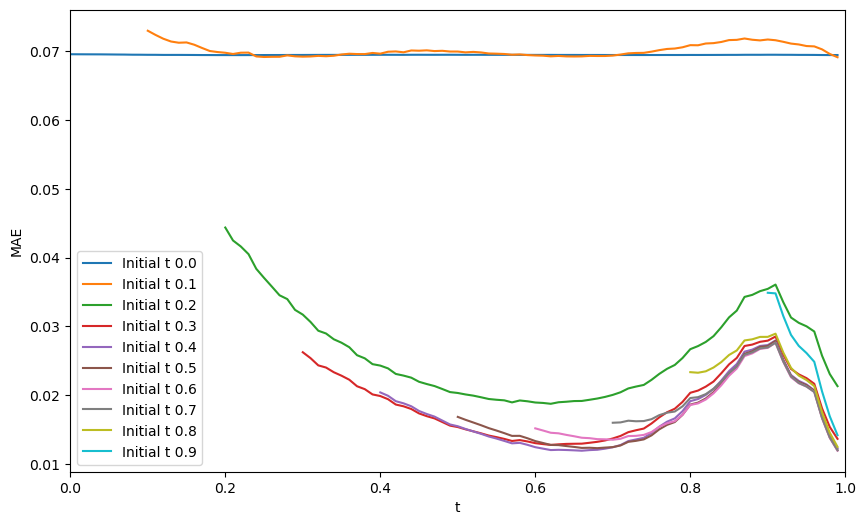

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for key, mse_values in mse_log.items(): 
    plt.plot(x_log[key]/100, np.sqrt(mse_values), label=f'Initial t {key/100}')

plt.xlabel('t')
plt.xlim(0,1)
plt.ylabel('MAE')
plt.legend()
plt.show()

In [66]:
mse

tensor(0.0003, device='cuda:0')

In [37]:
batch.shape

torch.Size([1, 181, 1280])

In [36]:
len(set(struct_tokens.flatten().cpu().numpy().tolist()))

170

In [ ]:
struct_tokens, distances, second_distances = convert_continuous_to_discrete_token(batch)
first_protein_chain = decode(struct_tokens)

# print(torch.mean(distances))

first_protein_chain.to_pdb("orig.pdb")

torch.Size([129])


In [40]:
os.listdir('/manitou/pmg/projects/resources/openfold_data/data/pdb_mmcif/mmcif_files')

['1j0k.cif',
 '3mal.cif',
 '3awu.cif',
 '6z4n.cif',
 '2oyh.cif',
 '4om4.cif',
 '5qz5.cif',
 '3upy.cif',
 '1vbg.cif',
 '8d7b.cif',
 '2fby.cif',
 '2rdj.cif',
 '6gp7.cif',
 '1iqt.cif',
 '2fgl.cif',
 '5ojg.cif',
 '5vf4.cif',
 '2hdp.cif',
 '7f92.cif',
 '7tk8.cif',
 '3apg.cif',
 '7su8.cif',
 '5mxp.cif',
 '7biv.cif',
 '4ku4.cif',
 '7zoc.cif',
 '6jvf.cif',
 '4cvy.cif',
 '7elc.cif',
 '1rhr.cif',
 '1bmp.cif',
 '5ebj.cif',
 '3mkr.cif',
 '3rpr.cif',
 '2v15.cif',
 '7q3y.cif',
 '8i8l.cif',
 '7mij.cif',
 '4km6.cif',
 '6l8k.cif',
 '6mjh.cif',
 '5p2v.cif',
 '4qfk.cif',
 '7wsh.cif',
 '3hhh.cif',
 '5ty8.cif',
 '2pu9.cif',
 '3kqr.cif',
 '2j4w.cif',
 '2dbv.cif',
 '4ot1.cif',
 '6j3m.cif',
 '3gtd.cif',
 '7y84.cif',
 '4yzm.cif',
 '5aqk.cif',
 '7u57.cif',
 '4c4x.cif',
 '3qnr.cif',
 '3o35.cif',
 '6y80.cif',
 '2afg.cif',
 '4zwq.cif',
 '3rgd.cif',
 '8gym.cif',
 '8i1d.cif',
 '4y32.cif',
 '4l32.cif',
 '7e9y.cif',
 '2l78.cif',
 '2qgn.cif',
 '4xbe.cif',
 '5x0s.cif',
 '6e6v.cif',
 '5aoq.cif',
 '4axd.cif',
 '2l50.cif',

<Axes: ylabel='Count'>

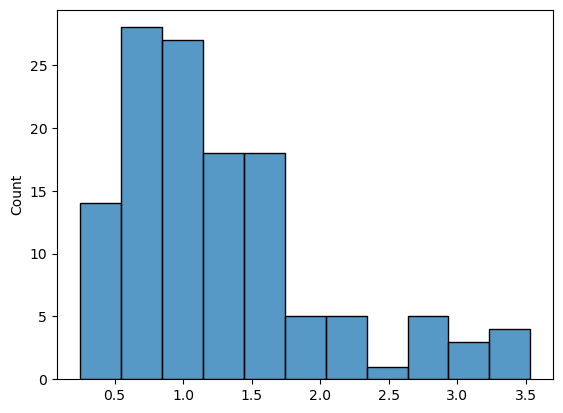

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(distances[2].detach().cpu().numpy())

(0.0, 5.0)

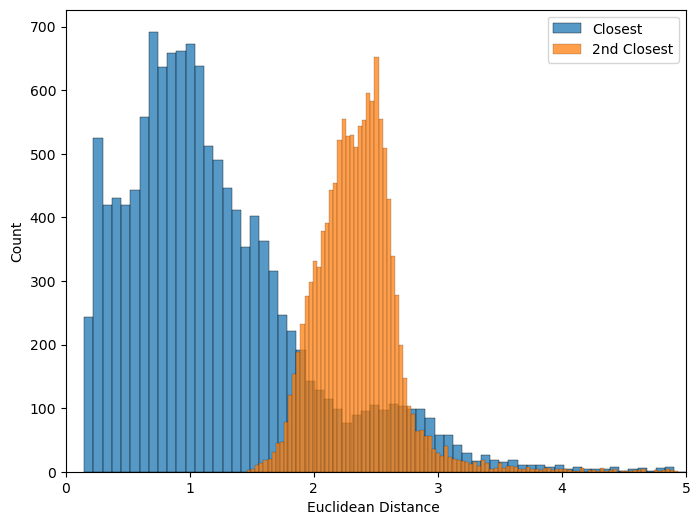

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.histplot(distances.flatten().cpu().detach().numpy(), label = "Closest")
sns.histplot(second_distances.flatten().cpu().detach().numpy(), label = "2nd Closest")
plt.xlabel("Euclidean Distance ")
plt.legend()
plt.xlim(0,5)

In [10]:
convert_continuous_to_discrete_token(x)

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


(tensor([[2874, 3961, 2048,  ..., 2605, 2585, 3961],
         [3961, 1450,  987,  ..., 3961, 1197, 2056],
         [1184,  264, 3961,  ..., 2056, 2000, 2048],
         ...,
         [2048, 1197, 2082,  ..., 1156, 2048,  321],
         [1476, 3961, 2056,  ..., 2000,  123, 3524],
         [1898, 4099, 2056,  ..., 2048, 1442, 2048]], device='cuda:0'),
 tensor([[0.4328, 1.1549, 0.6283,  ..., 2.2155, 1.4120, 0.8643],
         [1.5256, 1.2791, 0.9665,  ..., 0.9922, 0.7320, 0.9278],
         [2.7966, 0.9910, 1.3428,  ..., 1.7935, 2.9162, 0.9362],
         ...,
         [1.0351, 0.7938, 0.3352,  ..., 2.3184, 0.9722, 1.2021],
         [1.7755, 1.9993, 0.7860,  ..., 2.3077, 1.4263, 2.3758],
         [2.5942, 2.5468, 1.1889,  ..., 0.8952, 2.7368, 1.1316]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [12]:
torch.sqrt(torch.sum((vocab[2083]-vocab[332])**2))

tensor(3.5823, device='cuda:0', grad_fn=<SqrtBackward0>)

In [13]:
convert_continuous_to_discrete_token(x)

(tensor([[2874, 3961, 2048,  ..., 2605, 2585, 3961],
         [3961, 1450,  987,  ..., 3961, 1197, 2056],
         [1184,  264, 3961,  ..., 2056, 2000, 2048],
         ...,
         [2048, 1197, 2082,  ..., 1156, 2048,  321],
         [1476, 3961, 2056,  ..., 2000,  123, 3524],
         [1898, 4099, 2056,  ..., 2048, 1442, 2048]], device='cuda:0'),
 tensor([[0.4328, 1.1549, 0.6283,  ..., 2.2155, 1.4120, 0.8643],
         [1.5256, 1.2791, 0.9665,  ..., 0.9922, 0.7320, 0.9278],
         [2.7966, 0.9910, 1.3428,  ..., 1.7935, 2.9162, 0.9362],
         ...,
         [1.0351, 0.7938, 0.3352,  ..., 2.3184, 0.9722, 1.2021],
         [1.7755, 1.9993, 0.7860,  ..., 2.3077, 1.4263, 2.3758],
         [2.5942, 2.5468, 1.1889,  ..., 0.8952, 2.7368, 1.1316]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [14]:
def compute_row_distances(tensor):
    """
    Compute the Euclidean distance between each pair of rows in a 2D tensor.
    
    Args:
        tensor (torch.Tensor): A 2D tensor of shape [N, D].
        
    Returns:
        list: A list of distances between each pair of rows.
    """
    # Compute pairwise Euclidean distances
    distances = torch.cdist(tensor, tensor, p=2)  # Shape [N, N]
    
    # Flatten the distances into a list
    distance_list = distances.view(-1).tolist()
    
    return distance_list

# Example
tensor = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32)
result = compute_row_distances(tensor)
print(result)

[0.0, 2.8284270763397217, 5.656854152679443, 2.8284270763397217, 0.0, 2.8284270763397217, 5.656854152679443, 2.8284270763397217, 0.0]


In [15]:
torch.cdist(vocab, vocab, p=2)

tensor([[5.9402e-03, 3.4917e+00, 3.6334e+00,  ..., 3.4333e+00, 3.2553e+00,
         2.5575e+00],
        [3.4917e+00, 5.2589e-03, 3.5302e+00,  ..., 3.4466e+00, 3.3473e+00,
         2.5226e+00],
        [3.6334e+00, 3.5302e+00, 6.0199e-03,  ..., 3.6056e+00, 3.4842e+00,
         2.6727e+00],
        ...,
        [3.4333e+00, 3.4466e+00, 3.6056e+00,  ..., 4.6834e-03, 3.1589e+00,
         2.4357e+00],
        [3.2553e+00, 3.3473e+00, 3.4842e+00,  ..., 3.1589e+00, 5.2589e-03,
         2.2680e+00],
        [2.5575e+00, 2.5226e+00, 2.6727e+00,  ..., 2.4357e+00, 2.2680e+00,
         1.0066e-03]], device='cuda:0', grad_fn=<ViewBackward0>)

In [31]:
dist_list = []
all_vocab_distances = torch.cdist(vocab, vocab, p=2)
offset = torch.eye(len(vocab)).to(device) * 1e6
all_vocab_distances += offset
for i in range(len(vocab)):
    distance = torch.min(all_vocab_distances[i])
    distance = torch.tensor([distance])
    dist_list += distance.tolist()

In [32]:
len(dist_list)

4100

(0.0, 5.0)

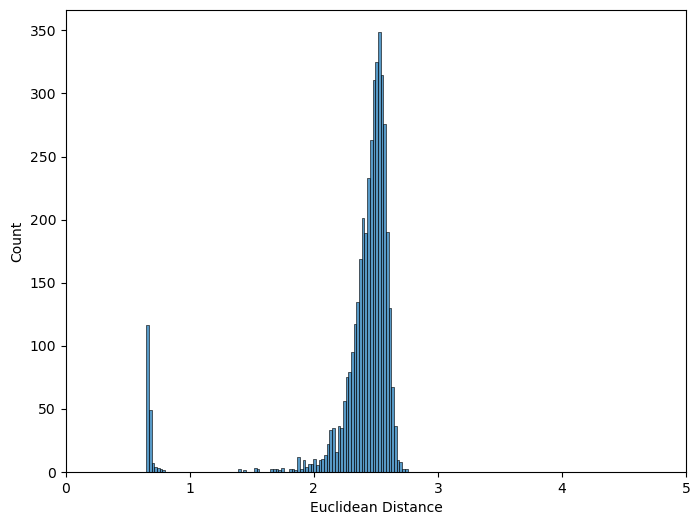

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.histplot(dist_list)
plt.xlabel("Euclidean Distance")
plt.xlim(0, 5)
